In [1]:
# Imports
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score
import xgboost as xgb

# Display
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
warnings.simplefilter('ignore')

# Defines
N_COMP = 12
N_JOBS = -1
SEED = 420


C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Read datasets
train = pd.read_csv("raw_data/train.csv")
test = pd.read_csv("raw_data/test.csv")


In [4]:
# Process columns, apply LabelEncoder to categorical features
for c in train.columns:
    if train[c].dtype == "object" :
        lbl = LabelEncoder() 
        lbl.fit(list(train[c].values) + list(test[c].values)) 
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))


In [5]:
# tSVD
tsvd = TruncatedSVD(n_components = N_COMP, random_state = SEED)
tsvd_results_train = tsvd.fit_transform(train.drop(["y"], axis = 1))
tsvd_results_test = tsvd.transform(test)

In [6]:
# PCA
pca = PCA(n_components = N_COMP, random_state = SEED)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis = 1))
pca2_results_test = pca.transform(test)

In [7]:
# ICA
ica = FastICA(n_components = N_COMP, random_state = SEED)
ica2_results_train = ica.fit_transform(train.drop(["y"], axis = 1))
ica2_results_test = ica.transform(test)

In [8]:
# GRP
grp = GaussianRandomProjection(n_components = N_COMP, random_state = SEED)
grp_results_train = grp.fit_transform(train.drop(["y"], axis = 1))
grp_results_test = grp.transform(test)

In [9]:
# SRP
srp = SparseRandomProjection(n_components = N_COMP, random_state = SEED)
srp_results_train = srp.fit_transform(train.drop(["y"], axis = 1))
srp_results_test = srp.transform(test)

In [10]:
# Append decomposition components to datasets
for i in range(1, N_COMP + 1):
    train["pca_" + str(i)] = pca2_results_train[:, i - 1]
    test["pca_" + str(i)] = pca2_results_test[:, i - 1]
    
    train["ica_" + str(i)] = ica2_results_train[:, i - 1]
    test["ica_" + str(i)] = ica2_results_test[:, i - 1]

    train["tsvd_" + str(i)] = tsvd_results_train[:, i - 1]
    test["tsvd_" + str(i)] = tsvd_results_test[:, i - 1]
    
    train["grp_" + str(i)] = grp_results_train[:, i - 1]
    test["grp_" + str(i)] = grp_results_test[:, i - 1]
    
    train["srp_" + str(i)] = srp_results_train[:, i - 1]
    test["srp_" + str(i)] = srp_results_test[:, i - 1]

In [11]:
# Prepare dict of params for xgboost to run with  
y_train = train["y"]
y_mean = np.mean(y_train)

xgb_params = {
    "n_trees": 520, 
    "eta": 0.0045,
    "max_depth": 4,
    "subsample": 0.93,
    "objective": "reg:linear",
    "eval_metric": "rmse",
    "base_score": y_mean,
    "silent": 1
}

# Form DMatrices for Xgboost training
dtrain = xgb.DMatrix(train.drop("y", axis = 1), y_train)
dtest = xgb.DMatrix(test)

# Train model
num_boost_rounds = 1250
model = xgb.train(dict(xgb_params, silent = 0), 
                  dtrain, 
                  num_boost_round = num_boost_rounds)

In [12]:
# Check r2-score
print(r2_score(dtrain.get_label(), model.predict(dtrain)))

0.684157306685


In [13]:
# Make predictions
y_pred = model.predict(dtest)
results = pd.DataFrame({"ID": test["ID"].astype(np.int32), "y": y_pred})


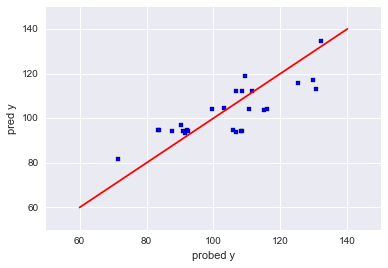

In [18]:
probe_ids = [1, 12, 23, 28, 42, 43, 45, 57, 72, 78, 88, 89, 93, 94, 104, 105, 110, 409, 493, 973, 1001, 1004, 1008, 1009, 
             3977, 4012]
probe_preds = results[results["ID"].isin(probe_ids)]

# Plot predictions
plt.scatter(new_y, probe_preds.y, c = "blue", marker = "s")
plt.xlabel("probed y")
plt.ylabel("pred y")
plt.plot([60, 140], [60, 140], c = "red")
plt.show()

In [ ]:
# Correct manually probed LB values
results.loc[results.ID == 1, "y"] = 71.34112
results.loc[results.ID == 12, "y"] = 109.30903
results.loc[results.ID == 23, "y"] = 115.21953
results.loc[results.ID == 28, "y"] = 92.00675
results.loc[results.ID == 42, "y"] = 87.73572
results.loc[results.ID == 43, "y"] = 129.79876
results.loc[results.ID == 45, "y"] = 99.55671
results.loc[results.ID == 57, "y"] = 116.02167
results.loc[results.ID == 72, "y"] = 110.54742
results.loc[results.ID == 78, "y"] = 125.28849
results.loc[results.ID == 88, "y"] = 90.33211
results.loc[results.ID == 89, "y"] = 130.55165
results.loc[results.ID == 93, "y"] = 105.79792
results.loc[results.ID == 94, "y"] = 103.04672
results.loc[results.ID == 104, "y"] = 92.37968
results.loc[results.ID == 105, "y"] = 108.5069
results.loc[results.ID == 110, "y"] = 83.31692
results.loc[results.ID == 409, "y"] = 91.0076
results.loc[results.ID == 493, "y"] = 108.40135
results.loc[results.ID == 973, "y"] = 106.76189
results.loc[results.ID == 1001, "y"] = 111.65212
results.loc[results.ID == 1004, "y"] = 91.472
results.loc[results.ID == 1008, "y"] = 106.71967
results.loc[results.ID == 1009, "y"] = 108.21841
results.loc[results.ID == 3977, "y"] = 132.08556
results.loc[results.ID == 4012, "y"] = 83.62651


In [ ]:
# Save results
display(results.head(15))
results.to_csv("preds/kaggle_baselane.csv", index = False) 